**import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import boxplot as bp
import math 
import regex as re
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm

**load dataset**

In [2]:
data = pd.read_csv('employee_reviews_sub.csv')

In [3]:
data.dtypes

Unnamed: 0                      int64
company                        object
location                       object
dates                          object
job-title                      object
overall-ratings               float64
work-balance-stars             object
culture-values-stars           object
carrer-opportunities-stars     object
comp-benefit-stars             object
senior-mangemnet-stars         object
helpful-count                   int64
link                           object
dtype: object

In [4]:
data.head()

,Unnamed: 0,company,location,dates,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


### Data Engeneering

In [5]:
#delete the useless columns
data = data.drop(['Unnamed: 0'], axis= 1)
#data = data.drop(['helpful-count'], axis= 1)
data = data.drop(['link'], axis= 1)

**Average ratings for different feature (by company)**. We use these information to fill the missing values in the rating fields.

In [6]:
ratings_comp = data[["company", 'overall-ratings', "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].copy()
ratings_comp.set_index(["company"], inplace=True)
ratings_comp = ratings_comp[~(ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()
avg_company.columns = ['Overall Ratings',"Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]
avg_company = avg_company.transpose()
avg_company

<ipython-input-6-83d9e7432d94>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_company = ratings_comp.groupby("company")['overall-ratings',"work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"].mean()


company,amazon,apple,facebook,google,microsoft,netflix
Overall Ratings,3.605707,3.958919,4.518081,4.378480,3.859934,3.497976
Work Balance,3.010915,3.338017,3.904729,4.004104,3.575086,3.210526
Culture Values,3.532292,4.097873,4.515299,4.359208,3.657359,3.514170
Career Opportunities,3.621241,3.419399,4.365090,4.030692,3.710211,3.157895
Company Benefits,3.710779,4.059036,4.573018,4.427552,4.025453,4.257085
Senior Management,3.171875,3.446916,4.260779,3.871877,3.185432,3.192308


In [7]:
companies=pd.unique(data['company'])
#in the following dict are stored the mean values for each comapany and each attribute using the previous dataframe avg_company
ratings_per_company={company: avg_company.loc[:,company].values for company in companies}  #companies are keys whereas values are the different ratings

for index,row in tqdm(data.iterrows()):  #for each row in the dataset  
    company=data.iloc[index,0]  #company name
    for index_y in range(4,10):  #for each column from overall ratings to helpful-count       
        if data.iloc[index,index_y]=='none':
            data.iloc[index,index_y]=round(ratings_per_company.get(company)[index_y-4],1)

67529it [00:54, 1248.67it/s]


In [8]:
#converting dtypes
data['culture-values-stars']=pd.to_numeric(data['culture-values-stars'])
data['work-balance-stars']=pd.to_numeric(data['work-balance-stars'])
data['carrer-opportunities-stars']=pd.to_numeric(data['carrer-opportunities-stars'])
data['comp-benefit-stars']=pd.to_numeric(data['comp-benefit-stars'])
data['senior-mangemnet-stars']=pd.to_numeric(data['senior-mangemnet-stars'])

In [9]:
#get rid of the row without location
data= data[data['location']!='none']
# add a column with the year only
data['year'] = pd.to_datetime(data['dates'], errors='coerce').dt.year
#delete the column with the dates
del data['dates']

In [10]:
data.head()

,company,location,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
1,google,"Mountain View, CA",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013.0
2,google,"New York, NY",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949,2014.0
3,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,2015.0
4,google,"Los Angeles, CA",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,2018.0
5,google,"Mountain View, CA",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,2018.0


In [14]:
#Use the data only with location in California
data_CA=data['location'].filter(regex='CA$',axis=0)
california_loc=pd.unique(list(filter(lambda loc:re.findall(r'CA$',loc),data['location'])))
data_CA=data[data['location'].isin(california_loc)]
#data_CA.head()

Save the processed dataframe into a file

In [12]:
data_CA.to_csv('processed_employee_reviews.csv')

In [13]:
data = pd.read_csv('processed_employee_reviews.csv')
data = data.drop(['Unnamed: 0'], axis= 1)

## Data analysis and visualization

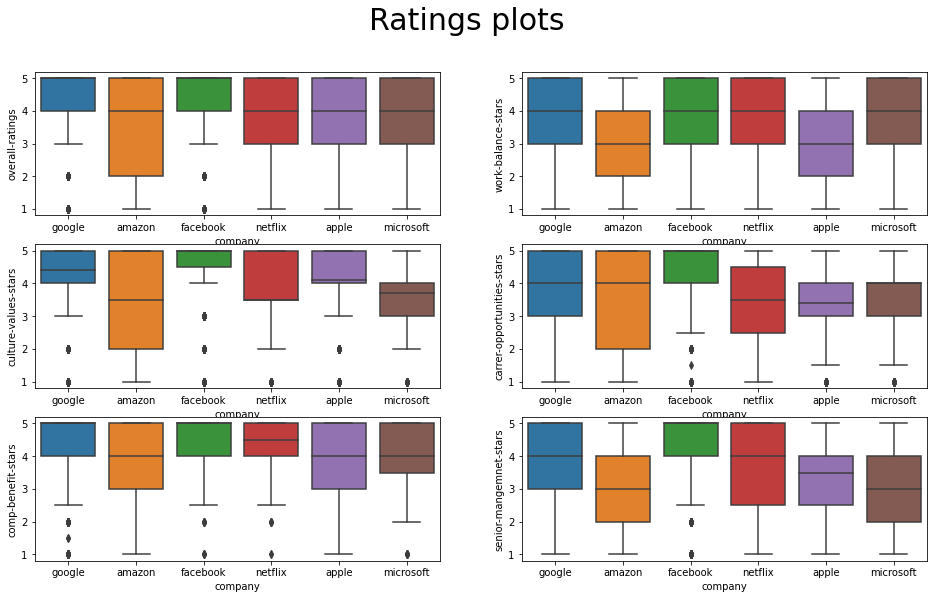

In [16]:
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(16,9))
fig.suptitle('Ratings plots',fontsize=30)
bp(x='company',y='overall-ratings',data=data,ax=axes[0,0])
bp(x='company',y='work-balance-stars',data=data,ax=axes[0,1])
bp(x='company',y='culture-values-stars',data=data,ax=axes[1,0])
bp(x='company',y='carrer-opportunities-stars',data=data,ax=axes[1,1])
bp(x='company',y='comp-benefit-stars',data=data,ax=axes[2,0])
bp(x='company',y='senior-mangemnet-stars',data=data,ax=axes[2,1])
plt.show()

#### Distribution of Reviews by year

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


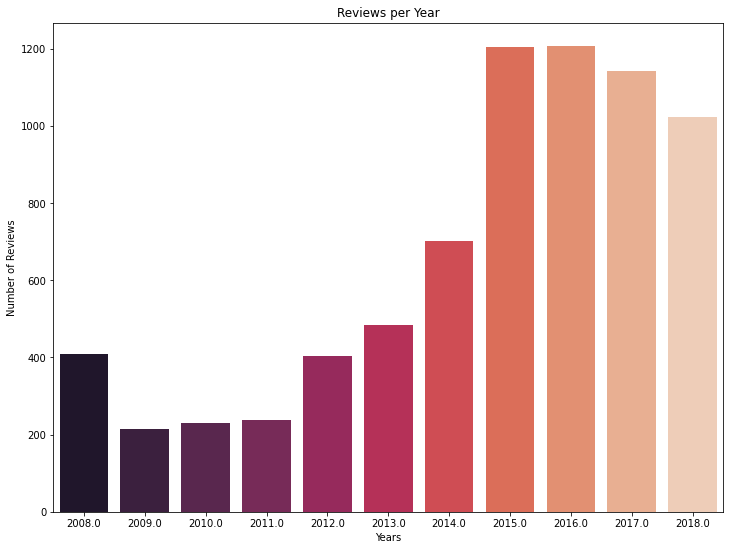

In [17]:
years_count = data_CA['year'].value_counts().sort_index(ascending=True)
years_labels = years_count.index.tolist()
years_index = np.arange(len(years_labels))

plt.figure(figsize=(12, 9))
_ = sns.barplot(years_index, years_count, palette='rocket')
_ = plt.xticks(years_index, years_labels)
_ = plt.xlabel("Years")
_ = plt.ylabel("Number of Reviews")
_ = plt.title("Reviews per Year")

### Which company takes the best treatment for the employees? 

(MAGARI QUESTI PLOT LI METTIAMO TUTTI INSIEME COME E' STATO FATTO PER I BOXPLOT)

In [18]:
def rating_per_company(rating_type, title, color):
    work_ratings = data[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(12, 10), color=color)
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    _ = plt.ylabel('Companies')

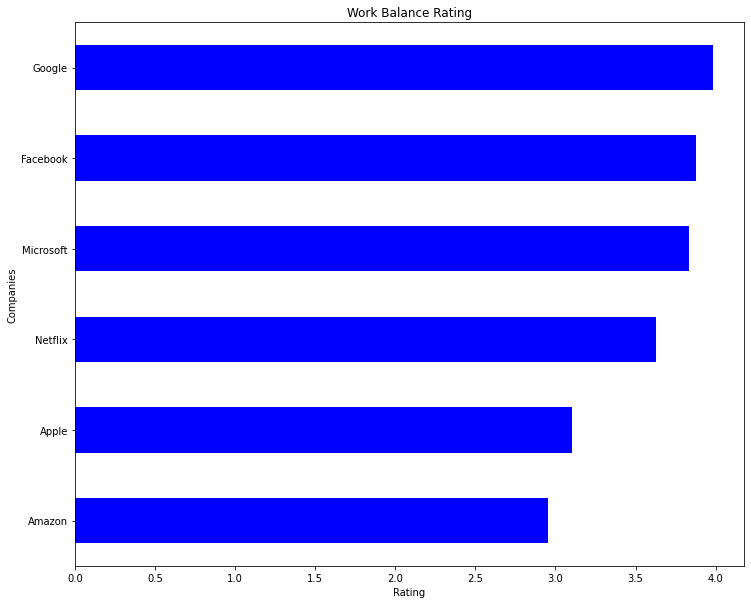

In [19]:
# Which company offers better Work-Life Balance?
rating_per_company('work-balance-stars', "Work Balance", "b")

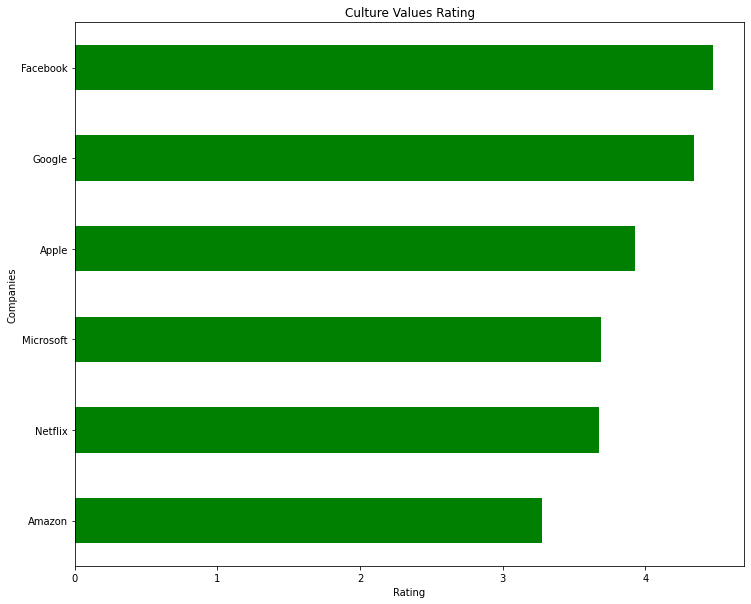

In [20]:
#Which company has better Culture Values?
rating_per_company('culture-values-stars', "Culture Values", "g")

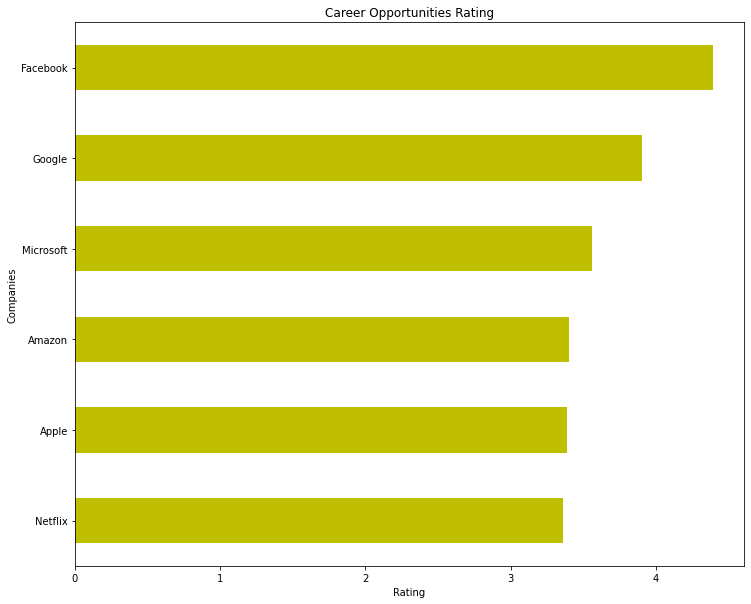

In [21]:
#Which company has better Career Opportunities?
rating_per_company("carrer-opportunities-stars", "Career Opportunities", "y")

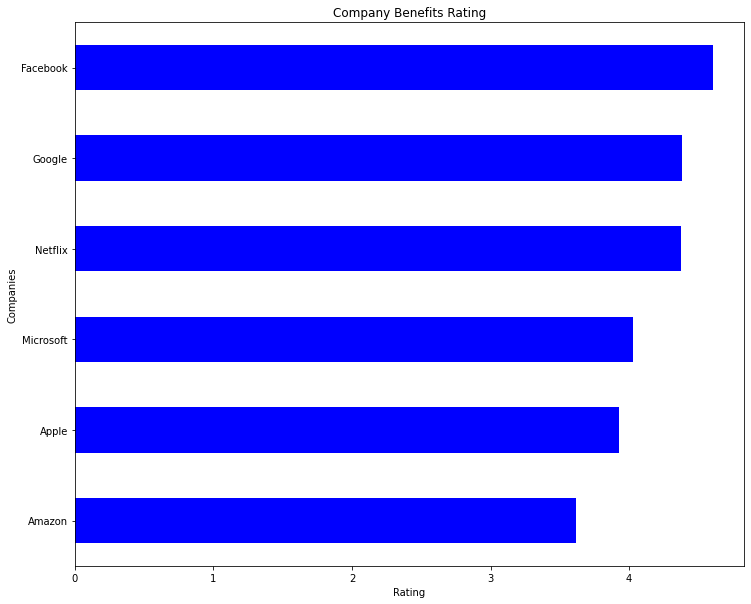

In [22]:
rating_per_company("comp-benefit-stars", "Company Benefits", "b")

## Normalizing the dataframe to explore the correlation between the features

In [23]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
data["Company_code"] =ord_enc.fit_transform(data[["company"]])
data["Job_code"]=ord_enc.fit_transform(data[["job-title"]])
data['Locations_code']=ord_enc.fit_transform(data[["location"]])

In [24]:
#delete the categorical&useless columns
data = data.drop(['company'], axis= 1)
data = data.drop(['location'], axis= 1)
data = data.drop(['job-title'], axis= 1)
data = data.drop(['year'], axis= 1)

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #for normalize the values
data_norm= scaler.fit_transform(data)
data_new=pd.DataFrame(data_norm,columns=["overall-ratings","work-balance-stars","culture-values-stars","carrer-opportunities-stars","comp-benefit-stars","senior-mangemnet-stars","helpful-count","Company_code","Job_code","Locations_code"])
data_new.to_csv('normalized_data.csv')

In [26]:
data_new.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Company_code,Job_code,Locations_code
0,0.75,0.25,0.50,0.50,1.00,0.50,1.000000,0.6,0.830282,0.517949
1,1.00,0.25,1.00,1.00,0.75,1.00,0.237822,0.6,0.020287,0.517949
2,1.00,1.00,1.00,1.00,1.00,1.00,0.023400,0.6,0.922316,0.410256
3,1.00,0.75,0.75,0.75,1.00,0.75,0.000478,0.6,0.851559,0.517949
4,1.00,0.75,1.00,0.75,0.75,0.50,0.000000,0.6,0.020287,0.517949


#### Now that we have only encoded data and the values are normalize, we can explore the correlations 

In [27]:
corr_matrix = data_new.corr()
corr_matrix

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Company_code,Job_code,Locations_code
overall-ratings,1.000000,0.603002,0.719810,0.717758,0.573054,0.730413,-0.057725,0.153446,-0.149378,0.015109
work-balance-stars,0.603002,1.000000,0.538494,0.487128,0.427564,0.579817,-0.059352,0.277916,-0.091613,0.089179
culture-values-stars,0.719810,0.538494,1.000000,0.586625,0.473530,0.679739,-0.051175,0.155848,-0.116036,-0.004365
carrer-opportunities-stars,0.717758,0.487128,0.586625,1.000000,0.554727,0.660001,-0.047716,0.107741,-0.117631,0.041321
comp-benefit-stars,0.573054,0.427564,0.473530,0.554727,1.000000,0.500802,-0.005771,0.226806,-0.046077,0.015356
senior-mangemnet-stars,0.730413,0.579817,0.679739,0.660001,0.500802,1.000000,-0.040167,0.142332,-0.134912,-0.025435
helpful-count,-0.057725,-0.059352,-0.051175,-0.047716,-0.005771,-0.040167,1.000000,0.034723,0.025016,-0.024591
Company_code,0.153446,0.277916,0.155848,0.107741,0.226806,0.142332,0.034723,1.000000,0.026377,0.054355
Job_code,-0.149378,-0.091613,-0.116036,-0.117631,-0.046077,-0.134912,0.025016,0.026377,1.000000,0.006841
Locations_code,0.015109,0.089179,-0.004365,0.041321,0.015356,-0.025435,-0.024591,0.054355,0.006841,1.000000


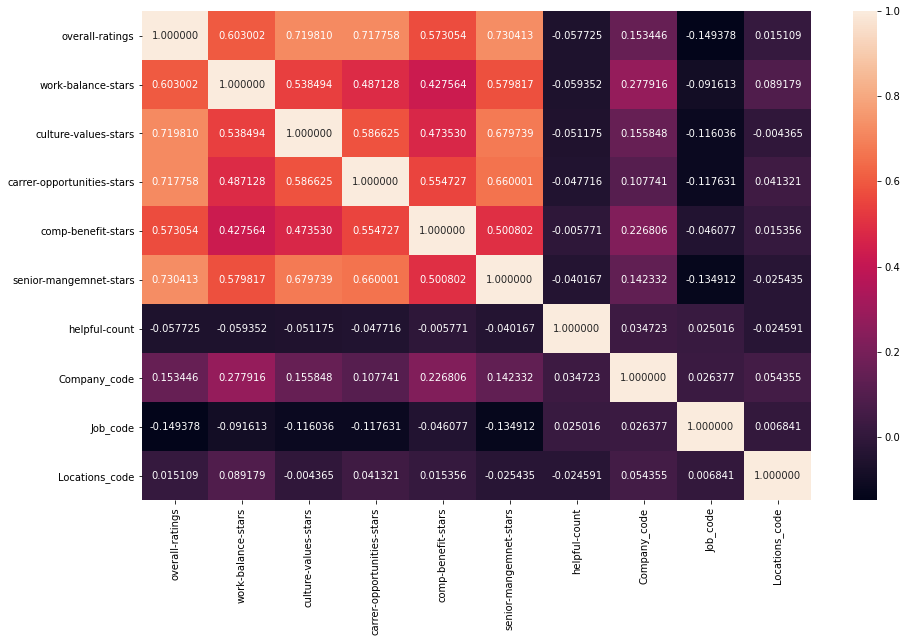

In [28]:
plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, fmt="f");

### From now on our analysis is based on each Company

In [71]:
def corr_matrix(df_company):
    df_company["Job_code"]=ord_enc.fit_transform(df_company[["job-title"]])
    df_company['Locations_code']=ord_enc.fit_transform(df_company[["location"]])

    #delete the categorical&useless columns
    df_company = df_company.drop(['company'], axis= 1)
    df_company = df_company.drop(['location'], axis= 1)
    df_company = df_company.drop(['job-title'], axis= 1)
    df_company = df_company.drop(['year'], axis= 1)

    #Normalize the values
    scaler = MinMaxScaler() 
    df_company_norm= scaler.fit_transform(df_company)
    df_company_new=pd.DataFrame(df_company_norm,columns=["overall-ratings","work-balance-stars","culture-values-stars","carrer-opportunities-stars","comp-benefit-stars","senior-mangemnet-stars","helpful-count","Job_code","Locations_code"])
    #compute the correlation matrix
    corr_df_company = df_company_new.corr()
    return (corr_df_company)

**Google**

In [66]:
# google=data[data['company']=='google']
# google.to_csv('google.csv')
google = pd.read_csv('google.csv')
del google['Unnamed: 0']

In [67]:
google.head()

,company,location,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
0,google,"Mountain View, CA",Former Employee - Program Manager,4.0,2.0,3.0,3.0,5.0,3.0,2094,2013.0
1,google,"New York, NY",Current Employee - Software Engineer III,5.0,5.0,4.0,5.0,5.0,4.0,949,2014.0
2,google,"Mountain View, CA",Current Employee - Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,2015.0
3,google,"Los Angeles, CA",Former Employee - Software Engineer,5.0,5.0,5.0,5.0,5.0,5.0,49,2018.0
4,google,"Mountain View, CA",Former Employee - SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,2018.0


In [68]:
fields = ['overall-ratings','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']
summary_google = google[fields].describe().transpose()

In [69]:
summary_google

,count,mean,std,min,25%,50%,75%,max
overall-ratings,4158.0,4.301347,0.964291,1.0,4.0,5.0,5.0,5.0
work-balance-stars,4158.0,3.981481,1.085427,1.0,3.0,4.0,5.0,5.0
culture-values-stars,4158.0,4.346320,0.903219,1.0,4.0,4.4,5.0,5.0
carrer-opportunities-stars,4158.0,3.910053,1.100862,1.0,3.0,4.0,5.0,5.0
comp-benefit-stars,4158.0,4.346441,0.864712,1.0,4.0,5.0,5.0,5.0
senior-mangemnet-stars,4158.0,3.817220,1.103779,1.0,3.0,4.0,5.0,5.0


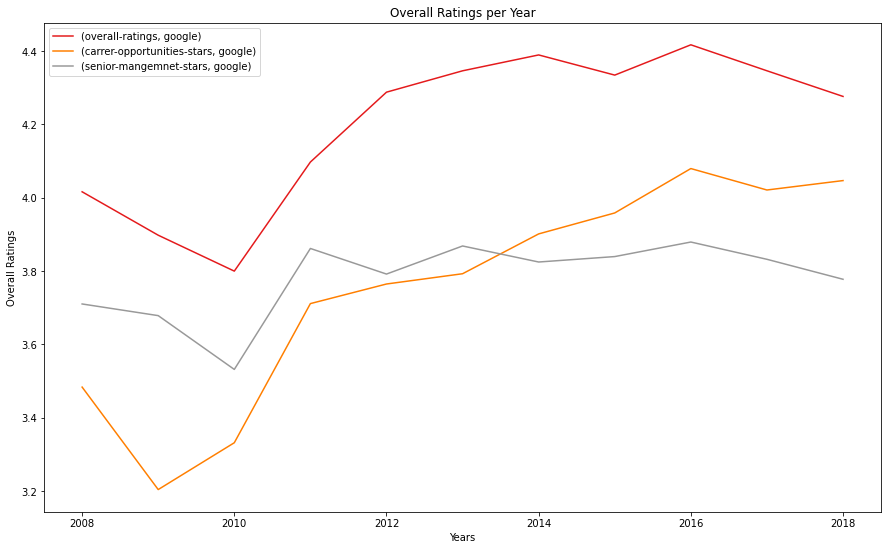

In [50]:
#Ratings over time for Google
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','carrer-opportunities-stars','senior-mangemnet-stars']
google.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Google**

In [72]:
corr_matrix(google)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.521767,0.616378,0.641013,0.482167,0.647143,-0.039539,-0.091972,0.021757
work-balance-stars,0.521767,1.000000,0.497289,0.410909,0.371769,0.518078,-0.049102,-0.025373,0.038134
culture-values-stars,0.616378,0.497289,1.000000,0.489991,0.411630,0.605130,-0.045568,-0.066048,0.023403
carrer-opportunities-stars,0.641013,0.410909,0.489991,1.000000,0.477543,0.591095,-0.034615,-0.039131,0.057142
comp-benefit-stars,0.482167,0.371769,0.411630,0.477543,1.000000,0.453748,-0.002096,0.007238,0.049757
senior-mangemnet-stars,0.647143,0.518078,0.605130,0.591095,0.453748,1.000000,-0.033371,-0.058699,0.038521
helpful-count,-0.039539,-0.049102,-0.045568,-0.034615,-0.002096,-0.033371,1.000000,0.018694,0.003037
Job_code,-0.091972,-0.025373,-0.066048,-0.039131,0.007238,-0.058699,0.018694,1.000000,0.050036
Locations_code,0.021757,0.038134,0.023403,0.057142,0.049757,0.038521,0.003037,0.050036,1.000000


**amazon**

In [73]:
# amazon=data[data['company']=='amazon']
# amazon.to_csv('amazon.csv')
amazon = pd.read_csv('amazon.csv')
del amazon['Unnamed: 0']
summary_amazon = amazon[fields].describe().transpose()

In [74]:
summary_amazon

,count,mean,std,min,25%,50%,75%,max
overall-ratings,16806.0,3.583363,1.298495,1.0,3.0,4.0,5.0,5.0
work-balance-stars,16806.0,3.040045,1.330507,1.0,2.0,3.0,4.0,5.0
culture-values-stars,16806.0,3.545549,1.355461,1.0,3.0,4.0,5.0,5.0
carrer-opportunities-stars,16806.0,3.603558,1.308810,1.0,3.0,4.0,5.0,5.0
comp-benefit-stars,16806.0,3.697995,1.122853,1.0,3.0,4.0,5.0,5.0
senior-mangemnet-stars,16806.0,3.184720,1.352742,1.0,2.0,3.0,4.0,5.0


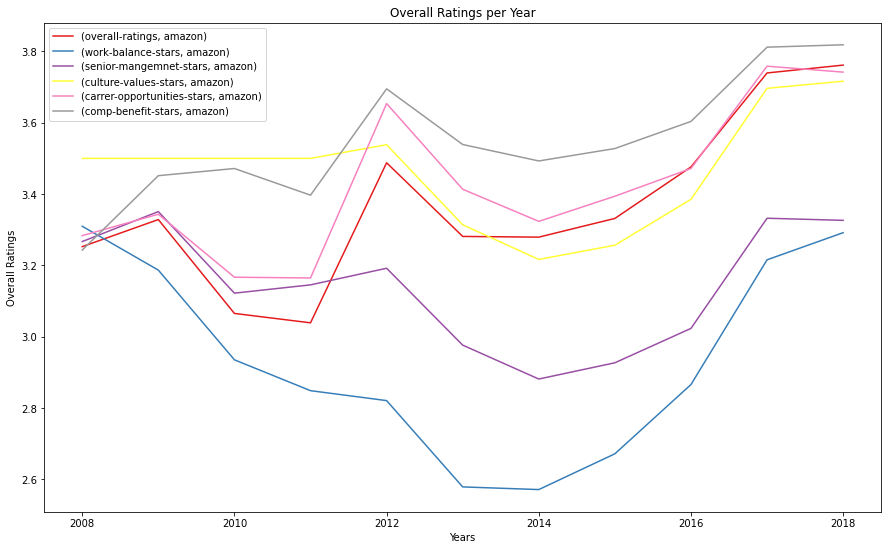

In [179]:
#Ratings over time for Amazon
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings', 'work-balance-stars','senior-mangemnet-stars', 'culture-values-stars', 'carrer-opportunities-stars', 'comp-benefit-stars']
amazon.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Amazon**

In [76]:
corr_matrix(amazon)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.658603,0.755126,0.721668,0.543276,0.735683,-0.046776,-0.200076,-0.047963
work-balance-stars,0.658603,1.000000,0.621683,0.510959,0.431752,0.625463,-0.041221,-0.165288,-0.076880
culture-values-stars,0.755126,0.621683,1.000000,0.646568,0.474040,0.726017,-0.039420,-0.182097,-0.066981
carrer-opportunities-stars,0.721668,0.510959,0.646568,1.000000,0.550387,0.673629,-0.031245,-0.177432,0.007209
comp-benefit-stars,0.543276,0.431752,0.474040,0.550387,1.000000,0.498529,-0.018262,-0.100112,-0.024205
senior-mangemnet-stars,0.735683,0.625463,0.726017,0.673629,0.498529,1.000000,-0.027556,-0.176707,-0.005506
helpful-count,-0.046776,-0.041221,-0.039420,-0.031245,-0.018262,-0.027556,1.000000,0.011693,0.039050
Job_code,-0.200076,-0.165288,-0.182097,-0.177432,-0.100112,-0.176707,0.011693,1.000000,0.023938
Locations_code,-0.047963,-0.076880,-0.066981,0.007209,-0.024205,-0.005506,0.039050,0.023938,1.000000


**apple**

In [78]:
# apple=data[data['company']=='apple']
# apple.to_csv('apple.csv')
apple = pd.read_csv('apple.csv')
del apple['Unnamed: 0']
summary_apple = apple[fields].describe().transpose()

In [79]:
summary_apple

,count,mean,std,min,25%,50%,75%,max
overall-ratings,7583.0,3.894105,1.091922,1.0,3.0,4.0,5.0,5.0
work-balance-stars,7583.0,3.332309,1.266562,1.0,2.0,3.3,4.0,5.0
culture-values-stars,7583.0,4.073137,1.088088,1.0,4.0,4.1,5.0,5.0
carrer-opportunities-stars,7583.0,3.364078,1.220753,1.0,3.0,3.4,4.0,5.0
comp-benefit-stars,7583.0,3.978069,1.000391,1.0,3.0,4.0,5.0,5.0
senior-mangemnet-stars,7583.0,3.413082,1.295530,1.0,3.0,4.0,4.5,5.0


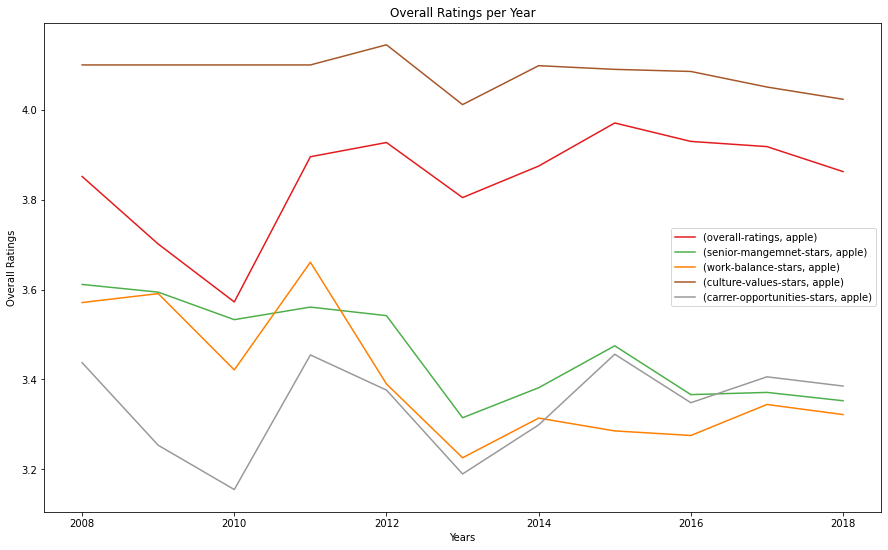

In [173]:
#Ratings over time for Apple
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','senior-mangemnet-stars','work-balance-stars','culture-values-stars','carrer-opportunities-stars']
apple.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Apple**

In [80]:
corr_matrix(apple)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.562918,0.652562,0.653245,0.509659,0.684976,-0.121660,-0.091089,0.021608
work-balance-stars,0.562918,1.000000,0.476680,0.443474,0.369437,0.543645,-0.104901,-0.057984,0.029817
culture-values-stars,0.652562,0.476680,1.000000,0.487426,0.393125,0.605700,-0.107740,-0.074761,0.041292
carrer-opportunities-stars,0.653245,0.443474,0.487426,1.000000,0.474867,0.617904,-0.067217,-0.093996,-0.022651
comp-benefit-stars,0.509659,0.369437,0.393125,0.474867,1.000000,0.418552,-0.065023,-0.056533,0.009896
senior-mangemnet-stars,0.684976,0.543645,0.605700,0.617904,0.418552,1.000000,-0.074923,-0.091249,-0.012677
helpful-count,-0.121660,-0.104901,-0.107740,-0.067217,-0.065023,-0.074923,1.000000,0.001074,-0.032085
Job_code,-0.091089,-0.057984,-0.074761,-0.093996,-0.056533,-0.091249,0.001074,1.000000,0.026739
Locations_code,0.021608,0.029817,0.041292,-0.022651,0.009896,-0.012677,-0.032085,0.026739,1.000000


**microsoft**

In [81]:
# microsoft=data[data['company']=='microsoft']
# microsoft.to_csv('microsoft.csv')
microsoft = pd.read_csv('microsoft.csv')
del microsoft['Unnamed: 0']
summary_microsoft = microsoft[fields].describe().transpose()

In [82]:
summary_microsoft

,count,mean,std,min,25%,50%,75%,max
overall-ratings,11745.0,3.769774,1.054439,1.0,3.0,4.0,5.0,5.0
work-balance-stars,11745.0,3.602801,1.139844,1.0,3.0,4.0,4.5,5.0
culture-values-stars,11745.0,3.650345,1.082185,1.0,3.0,3.7,4.0,5.0
carrer-opportunities-stars,11745.0,3.648931,1.071981,1.0,3.0,4.0,4.0,5.0
comp-benefit-stars,11745.0,4.010771,0.866511,1.0,3.5,4.0,5.0,5.0
senior-mangemnet-stars,11745.0,3.100758,1.200535,1.0,2.0,3.0,4.0,5.0


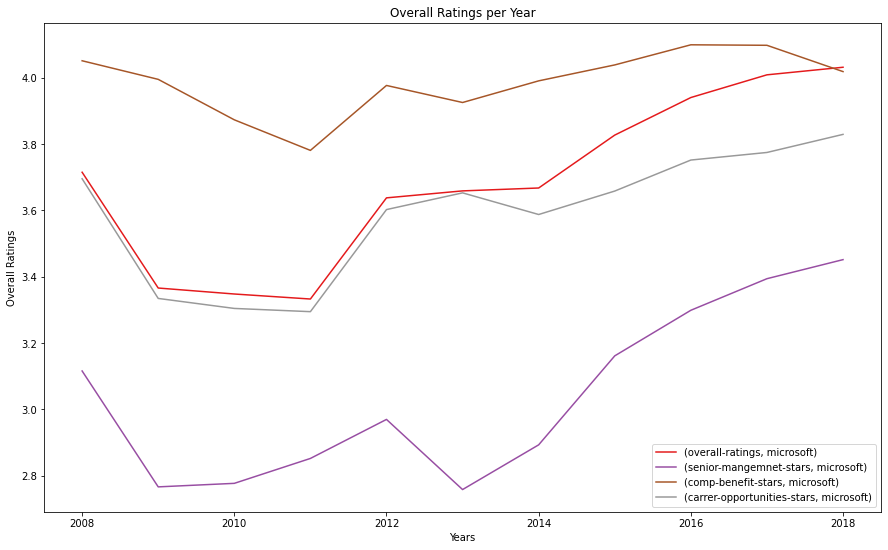

In [181]:
#Ratings over time for Microsoft
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','senior-mangemnet-stars', 'comp-benefit-stars', 'carrer-opportunities-stars']
microsoft.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Microsoft**

In [83]:
corr_matrix(microsoft)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.490425,0.630401,0.681214,0.462534,0.685189,-0.038518,-0.112894,-0.070793
work-balance-stars,0.490425,1.000000,0.445322,0.390688,0.319197,0.473142,-0.015069,-0.105004,0.007595
culture-values-stars,0.630401,0.445322,1.000000,0.493878,0.325642,0.624037,-0.037999,-0.105398,-0.079786
carrer-opportunities-stars,0.681214,0.390688,0.493878,1.000000,0.471812,0.584381,-0.043099,-0.061390,-0.024604
comp-benefit-stars,0.462534,0.319197,0.325642,0.471812,1.000000,0.379287,-0.019178,0.009642,0.007003
senior-mangemnet-stars,0.685189,0.473142,0.624037,0.584381,0.379287,1.000000,-0.029031,-0.111223,-0.070229
helpful-count,-0.038518,-0.015069,-0.037999,-0.043099,-0.019178,-0.029031,1.000000,-0.010216,0.005166
Job_code,-0.112894,-0.105004,-0.105398,-0.061390,0.009642,-0.111223,-0.010216,1.000000,0.006938
Locations_code,-0.070793,0.007595,-0.079786,-0.024604,0.007003,-0.070229,0.005166,0.006938,1.000000


**netflix**

In [84]:
# netflix=data[data['company']=='netflix']
# netflix.to_csv('netflix.csv')
netflix = pd.read_csv('netflix.csv')
del netflix['Unnamed: 0']
summary_netflix = netflix[fields].describe().transpose()

In [85]:
summary_netflix

,count,mean,std,min,25%,50%,75%,max
overall-ratings,562.0,3.345196,1.442314,1.0,2.0,4.0,5.0,5.0
work-balance-stars,562.0,3.196797,1.389260,1.0,2.0,3.0,4.0,5.0
culture-values-stars,562.0,3.474199,1.222105,1.0,3.0,3.5,4.0,5.0
carrer-opportunities-stars,562.0,3.001779,1.383696,1.0,2.0,3.0,4.0,5.0
comp-benefit-stars,562.0,4.095907,1.004003,1.0,4.0,4.0,5.0,5.0
senior-mangemnet-stars,562.0,3.149466,1.497202,1.0,2.0,3.0,4.5,5.0


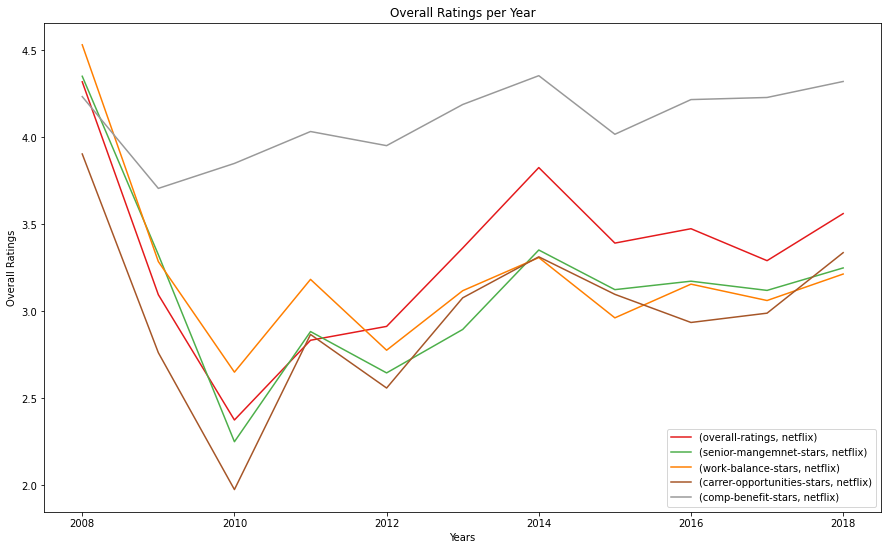

In [184]:
#Ratings over time for Netflix
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','senior-mangemnet-stars','work-balance-stars','carrer-opportunities-stars','comp-benefit-stars']
netflix.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Netflix**

In [87]:
corr_matrix(netflix)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.705203,0.638119,0.787651,0.556384,0.809285,-0.361691,-0.252499,0.062713
work-balance-stars,0.705203,1.000000,0.490146,0.597286,0.479457,0.722686,-0.264038,-0.172094,0.033308
culture-values-stars,0.638119,0.490146,1.000000,0.577682,0.456734,0.636024,-0.299336,-0.188257,0.037757
carrer-opportunities-stars,0.787651,0.597286,0.577682,1.000000,0.532082,0.757111,-0.278080,-0.202235,0.054342
comp-benefit-stars,0.556384,0.479457,0.456734,0.532082,1.000000,0.528137,-0.050992,-0.133386,0.093298
senior-mangemnet-stars,0.809285,0.722686,0.636024,0.757111,0.528137,1.000000,-0.305962,-0.270616,0.081399
helpful-count,-0.361691,-0.264038,-0.299336,-0.278080,-0.050992,-0.305962,1.000000,0.176086,-0.033450
Job_code,-0.252499,-0.172094,-0.188257,-0.202235,-0.133386,-0.270616,0.176086,1.000000,0.017682
Locations_code,0.062713,0.033308,0.037757,0.054342,0.093298,0.081399,-0.033450,0.017682,1.000000


**facebook**

In [86]:
# facebook=data[data['company']=='facebook']
# facebook.to_csv('facebook.csv')
facebook = pd.read_csv('facebook.csv')
del facebook['Unnamed: 0']
summary_facebook = facebook[fields].describe().transpose()

In [109]:
summary_facebook

,count,mean,std,min,25%,50%,75%,max
overall-ratings,1590.0,4.511950,0.955680,1.0,4.0,5.0,5.0,5.0
work-balance-stars,1590.0,3.927421,1.140055,1.0,3.0,4.0,5.0,5.0
culture-values-stars,1590.0,4.510063,0.941772,1.0,4.5,5.0,5.0,5.0
carrer-opportunities-stars,1590.0,4.358931,0.987425,1.0,4.0,5.0,5.0,5.0
comp-benefit-stars,1590.0,4.560943,0.737593,1.0,4.0,5.0,5.0,5.0
senior-mangemnet-stars,1590.0,4.264843,1.077402,1.0,4.0,5.0,5.0,5.0


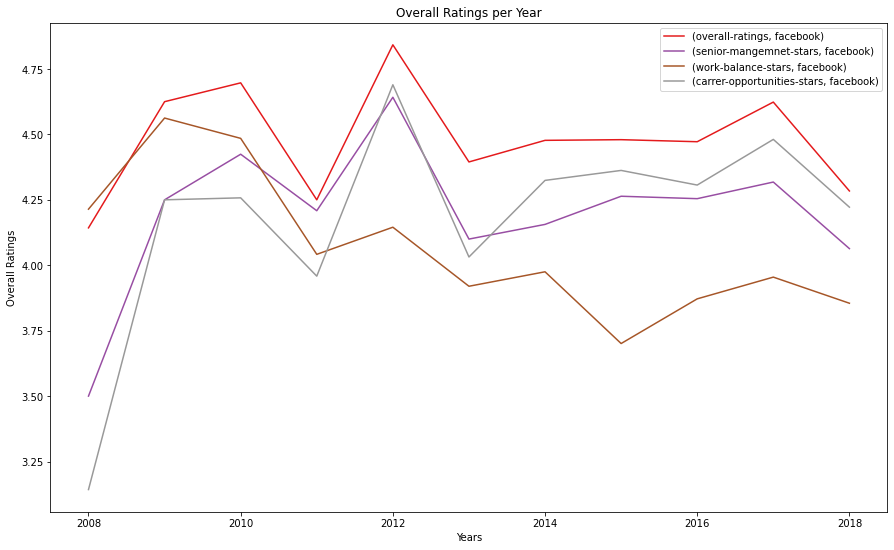

In [186]:
#Ratings over time for Facebook
fig, ax = plt.subplots(figsize=(15,9))
keys = ['year','company']
lines = ['overall-ratings','senior-mangemnet-stars','work-balance-stars','carrer-opportunities-stars']
facebook.groupby(keys)[lines].mean().unstack().plot(ax=ax,colormap = 'Set1')
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
_ = plt.legend()

**Test correlation for Facebook**

In [88]:
corr_matrix(facebook)

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,Job_code,Locations_code
overall-ratings,1.000000,0.584071,0.767267,0.746212,0.438975,0.750691,-0.166161,-0.223368,0.031748
work-balance-stars,0.584071,1.000000,0.552184,0.496728,0.356884,0.593187,-0.114598,-0.175402,-0.016466
culture-values-stars,0.767267,0.552184,1.000000,0.655536,0.381164,0.720621,-0.133298,-0.209151,-0.019004
carrer-opportunities-stars,0.746212,0.496728,0.655536,1.000000,0.522372,0.680094,-0.129489,-0.136273,0.062168
comp-benefit-stars,0.438975,0.356884,0.381164,0.522372,1.000000,0.467325,-0.038888,-0.038494,0.078558
senior-mangemnet-stars,0.750691,0.593187,0.720621,0.680094,0.467325,1.000000,-0.119486,-0.216996,0.023035
helpful-count,-0.166161,-0.114598,-0.133298,-0.129489,-0.038888,-0.119486,1.000000,0.072661,0.025783
Job_code,-0.223368,-0.175402,-0.209151,-0.136273,-0.038494,-0.216996,0.072661,1.000000,0.103987
Locations_code,0.031748,-0.016466,-0.019004,0.062168,0.078558,0.023035,0.025783,0.103987,1.000000


### Causal inference

**CAUSALITY CHECK**

- GOOGLE: 

'overall-ratings' - 'carrer-opportunities-stars' - 'senior-mangemnet-stars'


- AMAZON: 

'overall-ratings' - 'work-balance-stars’, 'senior-mangemnet-stars', 'culture-values-stars', 'carrer-opportunities-stars', 'comp-benefit-stars';


- FACEBOOK: 

'overall-ratings' - 'senior-mangemnet-stars', 'work-balance-stars', 'carrer-opportunities-stars'

- APPLE: 

'overall-ratings' - 'senior-mangemnet-stars', 'work-balance-stars', 'culture-values-stars','carrer-opportunities-stars';

- NETFLIX: 
 
'overall-ratings' - 'senior-mangemnet-stars', 'work-balance-stars', 'carrer-opportunities-stars','comp-benefit-stars'

- MICROSOFT: 

'overall-ratings' - 'senior-mangemnet-stars', 'comp-benefit-stars', ‘carrer-opportunities-stars';


In [34]:
import dowhy

## Classification 

In [63]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [124]:
# Encoding categorical data
ord_enc = OrdinalEncoder()

apple["Job_code"]=ord_enc.fit_transform(apple[["job-title"]])
apple["location_code"]=ord_enc.fit_transform(apple[["location"]])


google["Job_code"]=ord_enc.fit_transform(google[["job-title"]])
google["location_code"]=ord_enc.fit_transform(google[["location"]])


facebook["Job_code"]=ord_enc.fit_transform(facebook[["job-title"]])
facebook["location_code"]=ord_enc.fit_transform(facebook[["location"]])

### Train - test splitting

In [79]:
# we have to choose which cols are our features and which one is the target
# apple_jobs=apple[apple['Job_code']!=17.0]
# X = apple_jobs[['location_code','Job_code','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars','overall-ratings']]
# y = apple_jobs['helpful-count']
# # split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
# X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(X, y, test_size=0.30, random_state=42)

google_jobs=google[google['Job_code']!=17.0]
X = google_jobs[['location_code','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars','overall-ratings']]
y = google_jobs['helpful-count']
# split X and y into training and testing sets selecting at random the 30% of the rows and assigning them to the test_set
X_train_google, X_test_google, y_train_google, y_test_google = train_test_split(X, y, test_size=0.30, random_state=42)

### KNN Classifier

In [123]:
model=KNN()
model.fit(X_train_google,y_train_google)
model.score(X_test_google,y_test_google)

### SVM Classifier

In [122]:
model_1=SVC()
model_1.fit(X_train_google,y_train_google)
model_1.score(X_test_google,y_test_google)

### Decision tree Classifier

In [119]:
model_2=DecisionTreeClassifier()
model_2.fit(X_train_google,y_train_google)
model_2.score(X_test_google,y_test_google)